In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.9-cp36-none-any.whl size=73265 sha256=97abab96eea72d23e441edb4a6232823b05a417d5302e69a2a8f66a7de73b2e5
  Stored in directory: /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"yunsucho","key":"fc7b4196e3f713b8895b0ed95d1bcb6b"}'}

In [ ]:
 ! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
 ! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:51<00:00, 31.7MB/s]
100% 5.20G/5.20G [01:51<00:00, 49.9MB/s]


In [ ]:
!unzip /content/skin-cancer-mnist-ham10000.zip -d data

In [ ]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("/content/data"))

['HAM10000_images_part_1', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'ham10000_images_part_2', 'hmnist_8_8_L.csv', 'ham10000_images_part_1', 'HAM10000_images_part_2', 'hmnist_8_8_RGB.csv', 'HAM10000_metadata.csv']


In [ ]:
data_dir = '/content/data'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255. #normalize the image

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [ ]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original.head(4)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp


In [ ]:
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes


In [ ]:
df_original.head(-10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/data/ham10000_images_part_1/ISIC_0027...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/data/ham10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/data/ham10000_images_part_1/ISIC_0026...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/data/ham10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/data/HAM10000_images_part_2/ISIC_0031...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10000,HAM_0004282,ISIC_0033151,akiec,histo,65.0,female,face,/content/data/HAM10000_images_part_2/ISIC_0033...,Actinic keratoses,0
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,/content/data/HAM10000_images_part_2/ISIC_0031...,Actinic keratoses,0
10002,HAM_0006442,ISIC_0032947,akiec,histo,70.0,male,hand,/content/data/HAM10000_images_part_2/ISIC_0032...,Actinic keratoses,0
10003,HAM_0004592,ISIC_0029141,akiec,histo,60.0,female,face,/content/data/ham10000_images_part_1/ISIC_0029...,Actinic keratoses,0


In [ ]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head(-10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
5499,HAM_0007608,1,1,1,1,1,1,1,1,1
5500,HAM_0007609,1,1,1,1,1,1,1,1,1
5501,HAM_0007610,1,1,1,1,1,1,1,1,1
5502,HAM_0007611,1,1,1,1,1,1,1,1,1


In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/data/ham10000_images_part_1/ISIC_0027...,Benign keratosis-like lesions,2,duplicated,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/data/ham10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2,duplicated,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/data/ham10000_images_part_1/ISIC_0026...,Benign keratosis-like lesions,2,duplicated,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/data/ham10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2,duplicated,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/data/HAM10000_images_part_2/ISIC_0031...,Benign keratosis-like lesions,2,duplicated,train


In [ ]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [ ]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [ ]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [ ]:
df_val.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
4781,HAM_0000199,ISIC_0026127,nv,follow_up,55.0,male,lower extremity,/content/data/ham10000_images_part_1/ISIC_0026...,Melanocytic nevi,4,unduplicated
3294,HAM_0006655,ISIC_0025994,nv,follow_up,50.0,female,lower extremity,/content/data/ham10000_images_part_1/ISIC_0025...,Melanocytic nevi,4,unduplicated
2089,HAM_0006004,ISIC_0027702,mel,histo,70.0,female,back,/content/data/ham10000_images_part_1/ISIC_0027...,dermatofibroma,6,unduplicated


In [ ]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [ ]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)

# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))


8912
1103


In [ ]:
df_train['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

In [ ]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [ ]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [ ]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
# df_test = df_test.reset_index()

In [ ]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
      
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [ ]:
# resnet,vgg,densenet,inception
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
norm_mean = (0.49139968, 0.48215827, 0.44653124)
norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(),transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

visualization_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    ])

In [ ]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

visualization_set = HAM10000(df_val, transform=visualization_transform )
visualization_loader = DataLoader(visualization_set, batch_size=32, shuffle=False, num_workers=4)

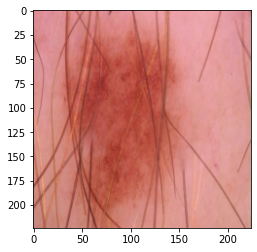

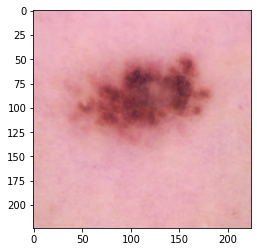

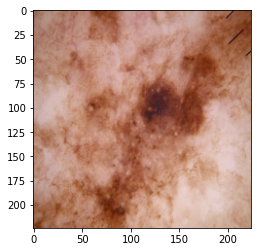

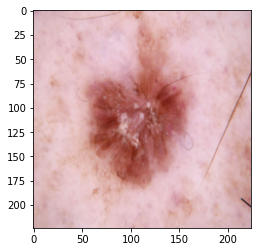

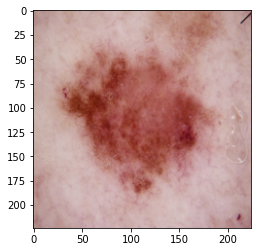

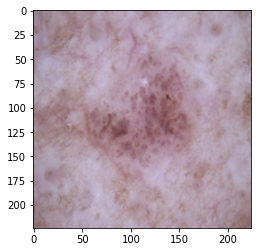

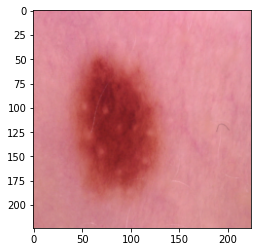

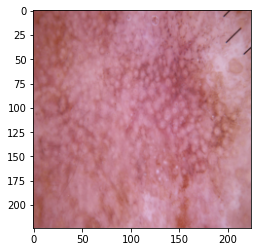

In [ ]:

for ii, (inputs, labels) in enumerate(visualization_loader):
  
  for i in range(0,8):
    plt.figure()
    plt.imshow(inputs[i].numpy().transpose(1,2,0)) 



  break


In [ ]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [ ]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [ ]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.28645], [train acc 0.52156]
[epoch 1], [iter 200 / 1124], [train loss 1.15930], [train acc 0.56406]
[epoch 1], [iter 300 / 1124], [train loss 1.08182], [train acc 0.59510]
[epoch 1], [iter 400 / 1124], [train loss 1.02637], [train acc 0.61438]
[epoch 1], [iter 500 / 1124], [train loss 0.98291], [train acc 0.63187]
[epoch 1], [iter 600 / 1124], [train loss 0.94554], [train acc 0.64568]
[epoch 1], [iter 700 / 1124], [train loss 0.91600], [train acc 0.65661]
[epoch 1], [iter 800 / 1124], [train loss 0.88740], [train acc 0.66762]
[epoch 1], [iter 900 / 1124], [train loss 0.86606], [train acc 0.67569]
[epoch 1], [iter 1000 / 1124], [train loss 0.84557], [train acc 0.68306]
[epoch 1], [iter 1100 / 1124], [train loss 0.83079], [train acc 0.68815]
------------------------------------------------------------
[epoch 1], [val loss 0.43431], [val acc 0.86149]
------------------------------------------------------------
***********************************

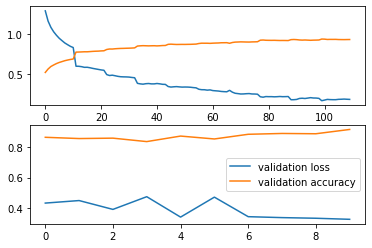

In [ ]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

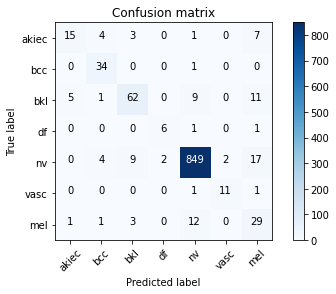

In [ ]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.71      0.50      0.59        30
         bcc       0.77      0.97      0.86        35
         bkl       0.81      0.70      0.75        88
          df       0.75      0.75      0.75         8
          nv       0.97      0.96      0.97       883
        vasc       0.85      0.85      0.85        13
         mel       0.44      0.63      0.52        46

    accuracy                           0.91      1103
   macro avg       0.76      0.77      0.75      1103
weighted avg       0.92      0.91      0.91      1103



Text(0, 0.5, 'Fraction classified incorrectly')

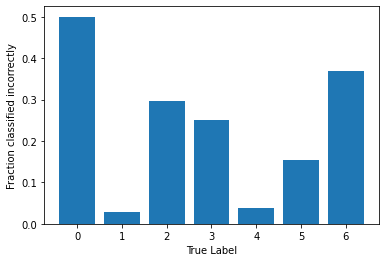

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')